<a href="https://colab.research.google.com/github/SharmaAarohi/Image-Feature-Extraction/blob/main/image_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q tensorflow opencv-python-headless scikit-image matplotlib seaborn scikit-learn tqdm

In [ ]:
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [ ]:
from skimage.color import rgb2gray
from skimage.feature import hog


from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
import gc

In [ ]:
from tensorflow.keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X = np.concatenate([X_train, X_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0).ravel()


print('Loaded CIFAR-10: images=', X.shape, 'labels=', y.shape)

Loaded CIFAR-10: images= (60000, 32, 32, 3) labels= (60000,)


In [ ]:
subset = 5000
X = X[:subset]
y = y[:subset]

In [ ]:
def extract_hog(image):
    # image: RGB uint8 0-255, small size 32x32
    gray = rgb2gray(image)
    h = hog(gray, orientations=9, pixels_per_cell=(8,8),
            cells_per_block=(2,2), block_norm='L2-Hys', feature_vector=True)
    return h

In [ ]:
def extract_color_hist(image, bins=8):
    # image in RGB
    chans = cv2.split(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    hist = []
    for ch in chans:
        h = cv2.calcHist([ch], [0], None, [bins], [0,256])
        h = cv2.normalize(h, h).flatten()
        hist.extend(h.tolist())
    return np.array(hist)

In [ ]:
def extract_orb_pool(image, descriptor_size=128):
  gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  orb = cv2.ORB_create(nfeatures=150)
  kp, des = orb.detectAndCompute(gray, None)


  if des is None or len(des) == 0:
    return np.zeros(descriptor_size * 2)


  des = des.astype(np.float32)
  if des.shape[1] < descriptor_size:
    pad = np.zeros((des.shape[0], descriptor_size - des.shape[1]), dtype=np.float32)
    des = np.concatenate([des, pad], axis=1)


  mean = des.mean(axis=0)
  std = des.std(axis=0)
  return np.concatenate([mean, std])

In [ ]:
base = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
x = GlobalAveragePooling2D()(base.output)
vgg_model = Model(base.input, x)
print('VGG16 output shape:', vgg_model.output_shape)

VGG16 output shape: (None, 512)


In [ ]:
batch_size = 32
n = X.shape[0]


hog_feats = []
orb_feats = []
color_feats = []
vgg_feats = []


batch_imgs = []


print('Extracting features...')
start = time.time()

for i in tqdm(range(n)):
  img = X[i]


  # handcrafted
  hog_feats.append(extract_hog(img))
  orb_feats.append(extract_orb_pool(img))
  color_feats.append(extract_color_hist(img))


  # VGG batch
  img_r = cv2.resize(img, (224,224))
  batch_imgs.append(img_r)


if len(batch_imgs) == batch_size or i == n-1:
  arr = np.array(batch_imgs).astype(np.float32)
  arr = preprocess_input(arr)
  v = vgg_model.predict(arr, verbose=0)
  for fv in v:
    vgg_feats.append(fv.flatten())
  batch_imgs = []
  gc.collect()


end = time.time()
print(f'Feature extraction done in {end-start:.1f}s')

hog_feats = np.array(hog_feats)
orb_feats = np.array(orb_feats)
color_feats = np.array(color_feats)
vgg_feats = np.array(vgg_feats)

print('Shapes:', hog_feats.shape, orb_feats.shape, color_feats.shape, vgg_feats.shape)

Extracting features...


100%|██████████| 5000/5000 [00:06<00:00, 827.41it/s]


Feature extraction done in 56.8s
Shapes: (5000, 324) (5000, 256) (5000, 24) (5000, 512)


In [ ]:
features = np.concatenate([hog_feats, orb_feats, color_feats, vgg_feats], axis=1)
print('Final feature shape:', features.shape)

Final feature shape: (5000, 1116)


In [ ]:
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(features, y, test_size=0.2,
stratify=y, random_state=42)
print('Train/Test:', X_train_f.shape, X_test_f.shape)


# scaling for LR
scaler = StandardScaler().fit(X_train_f)
X_train_scaled = scaler.transform(X_train_f)
X_test_scaled = scaler.transform(X_test_f)

Train/Test: (4000, 1116) (1000, 1116)


RF Accuracy: 0.726
              precision    recall  f1-score   support

           0       0.73      0.78      0.76       101
           1       0.93      0.86      0.89        92
           2       0.71      0.55      0.62       104
           3       0.56      0.57      0.56        97
           4       0.67      0.62      0.65       104
           5       0.59      0.65      0.62        97
           6       0.77      0.79      0.78       104
           7       0.67      0.66      0.67        97
           8       0.84      0.88      0.86       104
           9       0.79      0.91      0.85       100

    accuracy                           0.73      1000
   macro avg       0.73      0.73      0.72      1000
weighted avg       0.73      0.73      0.72      1000



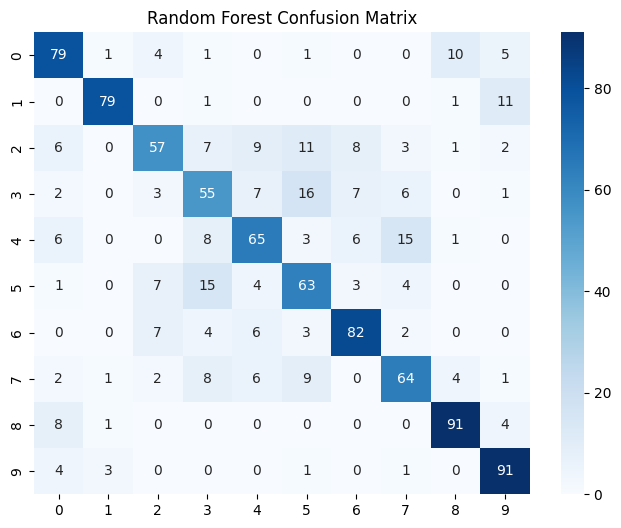

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_f, y_train_f)
rf_pred = rf.predict(X_test_f)


print('RF Accuracy:', accuracy_score(y_test_f, rf_pred))
print(classification_report(y_test_f, rf_pred))

cm_rf = confusion_matrix(y_test_f, rf_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LR Accuracy: 0.799
              precision    recall  f1-score   support

           0       0.85      0.81      0.83       101
           1       0.95      0.90      0.93        92
           2       0.64      0.73      0.68       104
           3       0.63      0.59      0.61        97
           4       0.77      0.79      0.78       104
           5       0.72      0.75      0.74        97
           6       0.90      0.84      0.87       104
           7       0.84      0.76      0.80        97
           8       0.85      0.88      0.87       104
           9       0.87      0.93      0.90       100

    accuracy                           0.80      1000
   macro avg       0.80      0.80      0.80      1000
weighted avg       0.80      0.80      0.80      1000



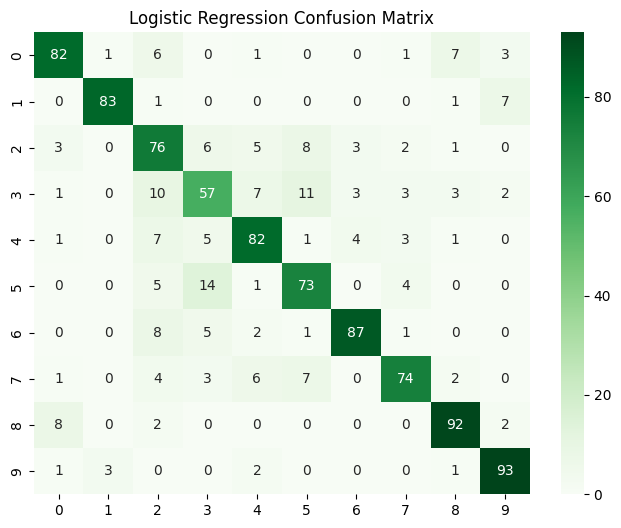

In [ ]:
lr = LogisticRegression(max_iter=500, solver='saga', multi_class='multinomial', n_jobs=-1)
lr.fit(X_train_scaled, y_train_f)
lr_pred = lr.predict(X_test_scaled)


print('LR Accuracy:', accuracy_score(y_test_f, lr_pred))
print(classification_report(y_test_f, lr_pred))


cm_lr = confusion_matrix(y_test_f, lr_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

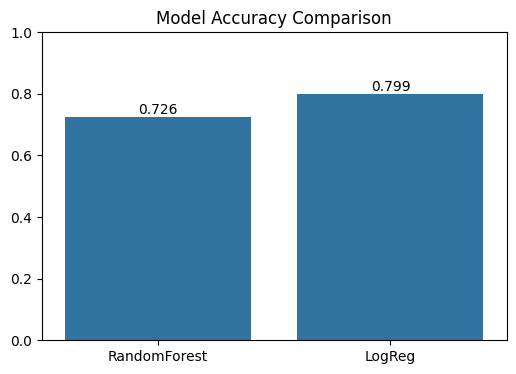

Execution complete.


In [ ]:
plt.figure(figsize=(6,4))
models = ['RandomForest','LogReg']
accs = [accuracy_score(y_test_f, rf_pred), accuracy_score(y_test_f, lr_pred)]
sns.barplot(x=models, y=accs)
plt.ylim(0,1)
plt.title('Model Accuracy Comparison')
for i,v in enumerate(accs):
  plt.text(i, v+0.01, f'{v:.3f}', ha='center')
plt.show()


print('Execution complete.')